<a href="https://colab.research.google.com/github/mafaldasalomao/DCGAN_MNIST_TENSORFLOW/blob/main/WGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.9.2'

In [2]:
(X_treinamento, y_treinamento), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
X_treinamento.shape, y_treinamento.shape

((60000, 28, 28), (60000,))

In [4]:
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float32')

In [5]:
X_treinamento.shape

(60000, 28, 28, 1)

In [6]:
X_treinamento = (X_treinamento - 127.5) / 127.5 

In [7]:
buffer_size = y_treinamento.shape[0] #60000
batch_size = 256

X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)

In [8]:
def cria_gerador():
  network = tf.keras.Sequential()

  network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(64, (5,5), padding='same', use_bias=False, strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(1, (5,5), padding='same', use_bias=False, strides=(2,2), activation='tanh'))

  network.summary()

  return network

In [9]:
gerador = cria_gerador()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [10]:
gerador.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [11]:
ruido = tf.random.normal([1, 100])
print(ruido)

tf.Tensor(
[[ 0.36371508  0.7726043  -0.57158846 -1.936252   -0.96492285 -0.16277894
  -1.2948645   1.241924   -1.8284353   0.45915896  1.0411582  -1.0678674
   0.19654045  0.711649   -0.4802368   0.17762811  0.97749066 -0.4346696
   0.8200661  -0.01663531 -0.18361142 -0.16843575  0.77384233  0.7811778
   1.4750248   0.21440664 -0.3202957  -1.0475799  -0.734285   -0.61272585
  -0.62640876 -0.66398716 -1.9712455  -0.65121347  0.4965487   0.37396494
   0.07513995 -0.17521943 -1.6059936   0.2566769   0.26467744  1.2908293
  -1.3880403  -1.0650915  -0.27267545 -0.3477996  -1.0139328   0.44734287
  -0.95542634 -1.7799598   1.4058275   1.0921543  -0.41679844 -0.87331426
  -0.08928747  0.1979796  -0.01494051  0.8453972  -0.6864098  -2.3021326
  -0.04727569 -0.33241117 -0.55504    -0.25464416 -1.8024435   0.45355478
  -1.8809769   2.8745859   2.2240067  -0.7605303  -2.3033123   1.4404445
  -0.11369891 -0.20958635 -0.88669235  0.3556284   1.7972772   1.0317622
   0.18543164 -0.37369412  0.29668

(1, 28, 28, 1)


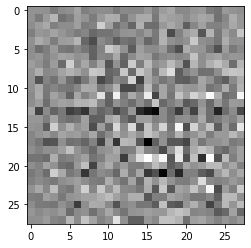

In [12]:
imagem_gerada = gerador(ruido, training = False)
print(imagem_gerada.shape)

plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray')

In [13]:
def cria_discriminador():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()
  return network

In [14]:
discriminador = cria_discriminador()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [15]:
discriminador.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [16]:
resultado = discriminador(imagem_gerada)
print(resultado)

tf.Tensor([[-0.00114205]], shape=(1, 1), dtype=float32)



## Funções de perda **Wasserstein Loss**

A perda (*loss*) é a diferença entre o valor esperado da saída do discriminador para imagens autênticas e o valor esperado do discriminador para imagens falsas que foram geradas. 

* O objetivo do discriminador é maximizar essa diferença, enquanto que o objetivo do gerador é minimizar. 

Então, podemos criar o loss/perda para podermos monitorar os estágios de treinamento. 

In [19]:
-1 * tf.math.reduce_mean([0.2, 0.9, 0.95])

<tf.Tensor: shape=(), dtype=float32, numpy=0.12843259>

In [18]:
def loss_gerador(fake_saida):
  g_loss = -1 * tf.math.reduce_mean(fake_saida)
  return g_loss

In [20]:
def loss_discriminador(real_saida, fake_saida, gradient_penalty):
  c_lambda = 10
  d_loss = tf.math.reduce_mean(fake_saida) - tf.math.reduce_mean(real_saida) + c_lambda * gradient_penalty
  return d_loss

## **Gradient Penalty**

- Parâmetros beta: https://stats.stackexchange.com/questions/265400/deep-learning-how-does-beta-1-and-beta-2-in-the-adam-optimizer-affect-its-lear#:~:text=The%20hyper%2Dparameters%20%CE%B21,each%20training%20step%20(batch).

 Para usar a perda de Wasserstein, nosso discriminador precisa ser **1-L** [(1-Lipschitz) contínuo](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/1-lipschitz-continuity-enforcement-GMPCt), ou seja, a norma do gradiente deve ser no máximo 1 em cada ponto.
 
Para impor a continuidade de 1-L usaremos o conceito de **Gradient Penalty**.

Essa variação foi apelidada de **WGAN-GP** (devido ao uso do **G**radient **P**enalty)

(Mais sobre Gradient Penalty [nesse artigo](https://towardsdatascience.com/demystified-wasserstein-gan-with-gradient-penalty-ba5e9b905ead))

Para calcular o gradient penalty faremos o seguinte:
1. Calcular uma imagem interpolada da imagem real e fake (`(real_image * epsilon + fake_image * (1 — epsilon))`)
2. Calcular o gradiente da saída do discriminador em relação à imagem interpolada. Depois disso, calcular a norma do gradiente.
3. Por fim, a penalidade é calculada como uma média do quadrado de (norma - 1), pois queremos que a norma seja próxima de um.

Para trabalhar com algumas das operações envolvendo gradiente usamos o  [GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape)

In [30]:
def gradient_penalty(real, fake, epsilon):
  imgs_interpoladas = real * epsilon + fake * (1- epsilon)
  with tf.GradientTape() as tape:
    tape.watch(imgs_interpoladas)
    scores = discriminador(imgs_interpoladas)
  gradient = tape.gradient(scores, imgs_interpoladas)[0]
  gradient_norm = tf.norm(gradient)
  gp = tf.math.reduce_mean((gradient_norm-1)**2)
  return gp

In [22]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefixo = os.path.join(checkpoint_dir, "checkpoints")
checkpoint = tf.train.Checkpoint(generator_optimizer = gerador_optimizer,
                                 discrimanator_optimizer = discriminador_optimizer,
                                 generator=gerador,
                                 discriminator=discriminador)

In [24]:
epochs = 30
noise_dim = 100
num_amostras = 16
seed = tf.random.normal([num_amostras, noise_dim])

In [25]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[-0.41720957,  0.06179711,  0.2883066 , ...,  1.2980283 ,
         0.38395756,  1.6853241 ],
       [ 0.15157852,  0.7760437 ,  0.33548477, ..., -0.80223024,
        -1.5477949 ,  0.8554114 ],
       [-0.15755336,  0.15367293, -0.78103846, ...,  0.28871486,
         0.73995274, -1.318616  ],
       ...,
       [ 0.11798235, -1.5549891 ,  0.08489182, ...,  1.267821  ,
         0.08496323, -1.2813225 ],
       [ 0.29129848, -0.9997965 , -1.0416497 , ..., -1.4605801 ,
         0.64125824,  1.4304931 ],
       [-0.5384848 ,  0.45972237,  0.9452507 , ..., -1.2142794 ,
        -0.61546844, -1.0343683 ]], dtype=float32)>

In [32]:
def etapa_treinamento(imgs):
  noise = tf.random.normal([batch_size, noise_dim])
  discriminador_etapas_extras = 3
  for i in range(discriminador_etapas_extras):
    with tf.GradientTape() as d_tape:
      imgs_geradas = gerador(noise, training=True)
      real_saida = discriminador(imgs, training=True)
      fake_saida = discriminador(imgs_geradas, training=True)
      epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
      gp = gradient_penalty(imgs, imgs_geradas, epsilon)

      d_loss = loss_discriminador(real_saida, fake_saida, gp)

    discriminador_gradientes = d_tape.gradient(d_loss, discriminador.trainable_variables)
    discriminador_optimizer.apply_gradients(zip(discriminador_gradientes, discriminador.trainable_variables))
  with tf.GradientTape() as g_tape:
    imgs_geradas = gerador(noise, training=True)
    fake_saida = discriminador(imgs_geradas, training=True)
    g_loss = loss_gerador(fake_saida)
  gerador_gradients = g_tape.gradient(g_loss, gerador.trainable_variables)
  gerador_optimizer.apply_gradients(zip(gerador_gradients, gerador.trainable_variables))

In [ ]:
#Sobre logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [27]:
def gerar_e_salvar_imgs(model, epoch, test_input):
  preds = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))
  for i in range(preds.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(preds[i, :, :, 0]*127.5 + 127.5, cmap='gray')
  plt.savefig('img_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [28]:
from tensorflow.python.ops.resource_variable_ops import eager_safe_variable_handle
def treinar(dataset, epochs):
  for epoch in range(epochs):
    inicio = time.time()
    for img_batch in dataset:
      if len(img_batch)==batch_size:
        etapa_treinamento(img_batch)
    display.clear_output(wait = True)
    gerar_e_salvar_imgs(gerador, epoch+1, seed)
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefixo)
      print('Tempo para processsar época {} foi de {} segundos'.format(epoch +1, time.time() - inicio))
  
  display.clear_output(wait = True)
  gerar_e_salvar_imgs(gerador, epochs, seed)
  gerador.save('gerador.h5')
  

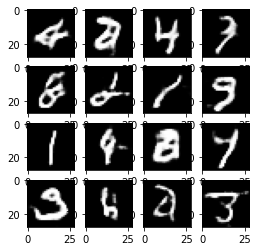

In [33]:
treinar(X_treinamento, epochs)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
seed_input = tf.random.normal([num_amostras, noise_dim])
preds = gerador(seed_input, training = False)
fig = plt.figure(figsize = (4,4))
for i in range(preds.shape[0]):
  plt.subplot(4,4,i+1)
  plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
  plt.axis('off')

> Mais implementações:

* https://github.com/robbiebarrat/art-DCGAN (baseado em DCGAN)
* https://github.com/tdrussell/IllustrationGAN (baseado em DCGAN)
* https://github.com/viuts/wgan-animefaces (baseado em WGAN)